# Settings up a Network of calculations

## First load inputs

Here we're defining a list of ligands (each a `openfe.SmallMoleculeComponent`) from a single sdf,
and a protein from a PDB file.

In [1]:
import openfe
from rdkit import Chem
from openff.units import unit

/Users/atravitz/micromamba/envs/openfe_env/lib/python3.13/site-packages/openmoltools/utils.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


In [2]:
# load ligands first into rdkit, then pass these into SmallMoleculeComponent containers
rdkit_ligands = list(Chem.SDMolSupplier('./inputs/Jnk1_ligands.sdf', removeHs=False))
ligands = [openfe.SmallMoleculeComponent.from_rdkit(l) for l in rdkit_ligands]

# protein straight from PDB to ProteinComponent
protein = openfe.ProteinComponent.from_pdb_file('./inputs/181L_mod_capped_protonated.pdb')

# define the abstract solvent
solvent = openfe.SolventComponent(
    positive_ion='Na', negative_ion='Cl',
    neutralize=True, ion_concentration=0.15*unit.molar
)

In [3]:
len(ligands)

21

## Define edges and mappings

Define the edges we wish to run,
each requiring a `LigandAtomMapping`,
generated by the `LomapAtomMapper`.

In [4]:
# give indices of all edges you want Lomap to form
# indices refer to the position within the variable `ligands`
edges = [
    (0, 1),
]

mapper = openfe.LomapAtomMapper(element_change=False,  # forbid element changes
                                time=300,  # large timeout
                                max3d=0.5)  # max 3d deviation

mappings = [
    next(mapper.suggest_mappings(ligands[i], ligands[j])) for i, j in edges
]

In [5]:
# fix up mappings
# Lomap currently allows some mismatches of >0.5 for hydrogens so remove these
fixed_mappings = []
for mapping in mappings:
    dists = mapping.get_distances()
    
    m = {i: j for (i, j), d in zip(mapping.componentA_to_componentB.items(), dists)
         if d < 0.5}
    
    fixed_mappings.append(
        openfe.LigandAtomMapping(componentA=mapping.componentA,
                                 componentB=mapping.componentB,
                                 componentA_to_componentB=m
                                )
    )
mappings = fixed_mappings

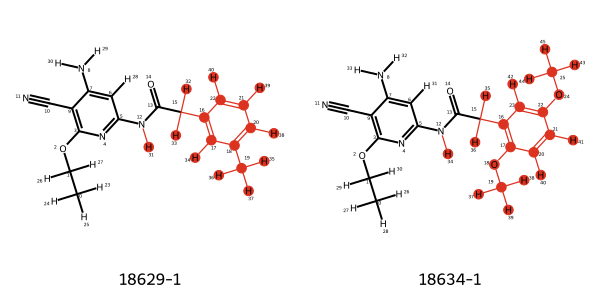

In [6]:
mappings[0]

In [7]:
mappings[0].view_3d(show_atomIDs=True)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Define what we will do to each edge (the Protocol)

In [8]:
from openfe.protocols import openmm_rfe


In [9]:
# generate default starting settings
# these are relatively sane, but can be tweaked
settings = openmm_rfe.RelativeHybridTopologyProtocol.default_settings()

# tweak to hearts content
settings.simulation_settings.equilibration_length = 6 * unit.picosecond
settings.simulation_settings.production_length = 6 * unit.picosecond
settings.protocol_repeats = 1  # number of completely independent runs, variance is std of means of these

# put Settings into Protocol
# the settings are now "locked in"/read-only and can't be further modified
# this is deliberate, the Protocol is now a fixed record of what you will do/have done
prot = openmm_rfe.RelativeHybridTopologyProtocol(settings)

## Apply Protocol onto Edges

For each edge we wanted to calculate, 
create both a solvent-only and complex `ChemicalSystem` by combining the various `Component`s we previously defined.
Then create a `Transformation` for each leg of the RBFE,
using the same `Protocol` object for each.

This creates a list of `Transformation` objects for both solvent and complex legs.

In [10]:
# build both a solvent and complex network
solvent_transforms = []
complex_transforms = []

for mapping in mappings:
    # solvent systems
    solv_sysA = openfe.ChemicalSystem({'solvent': solvent, 'ligand': mapping.componentA})
    solv_sysB = openfe.ChemicalSystem({'solvent': solvent, 'ligand': mapping.componentB})
    
    # complex systems
    comp_sysA = openfe.ChemicalSystem({'solvent': solvent, 'ligand': mapping.componentA,
                                     'protein': protein})
    comp_sysB = openfe.ChemicalSystem({'solvent': solvent, 'ligand': mapping.componentB,
                                     'protein': protein})
    
    solv_trans = openfe.Transformation(stateA=solv_sysA, stateB=solv_sysB,
                                      protocol=prot, mapping={'ligand': mapping})
    comp_trans = openfe.Transformation(stateA=comp_sysA, stateB=comp_sysB,
                                      protocol=prot, mapping={'ligand': mapping})
    
    solvent_transforms.append(solv_trans)
    complex_transforms.append(comp_trans)

/Users/atravitz/software/gufe/gufe/transformations/transformation.py:196: DeprecationWarning: mapping input as a dict is deprecated; instead use either a single Mapping or list
  warnings.warn(
/Users/atravitz/software/gufe/gufe/transformations/transformation.py:196: DeprecationWarning: mapping input as a dict is deprecated; instead use either a single Mapping or list
  warnings.warn(


## Write out Transformations

To farm out the jobs to multiple processes,
write the `Transformation` object to a json file on disk.

Creates a directory structure like this:

```
- work_rootdir/
  for each ligand pair:
  - {ligandA_name}_{ligandB_name}/
    - solvent/
      - transformation.json
    - complex/
      - transformation.json
```

In [11]:
!rm -r work_rootdir

rm: work_rootdir: No such file or directory


/Users/atravitz/micromamba/envs/openfe_env/lib/python3.13/pty.py:95: DeprecationWarning: This process (pid=20652) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


In [12]:
import os

rootname = 'work_rootdir'

os.mkdir(rootname)

for mapping, solv, comp in zip(mappings, solvent_transforms, complex_transforms):
    # requires that the Ligands have useful names
    # currently these are taken from the sdf file
    # but could also be set using `SmallMoleculeComponent(..., name="something")` on creation
    edgename = '{}_{}'.format(mapping.componentA.name, mapping.componentB.name)
    
    os.mkdir(os.path.join(rootname, edgename))
    
    os.mkdir(os.path.join(rootname, edgename, 'solvent'))
    solv.dump(os.path.join(rootname, edgename, 'solvent', 'transformation.json'))
    
    os.mkdir(os.path.join(rootname, edgename, 'complex'))
    comp.dump(os.path.join(rootname, edgename, 'complex', 'transformation.json'))


/Users/atravitz/software/gufe/gufe/transformations/transformation.py:124: DeprecationWarning: use of this method is deprecated; instead use `to_json`
  warnings.warn(
/Users/atravitz/software/gufe/gufe/transformations/transformation.py:124: DeprecationWarning: use of this method is deprecated; instead use `to_json`
  warnings.warn(


# Running the simulations

In each directory listed above, and run `openfe quickrun transformation.json -o results.json`

This will create a file called `results.json` containing the results of all repeats for a given leg.

The results can be loaded using json, by passing the `JSON_HANDLER.decoder` from `gufe` to assist in interpreting the special objects encoded within.

In [13]:
# NBVAL_SKIP
import gufe
import json

results = json.load(open('./work_rootdir/18629-1_18634-1/solvent/results.json', 'r'),
                    cls=gufe.tokenization.JSON_HANDLER.decoder)



FileNotFoundError: [Errno 2] No such file or directory: './work_rootdir/18629-1_18634-1/solvent/results.json'